## Load and unzip weatherdata

In [1]:
import pickle
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
from pandas import read_csv


def load_weather_data():
  dataset_slug = "pschale/nyc-taxi-wunderground-weather"
  zip_name = "nyc-taxi-wunderground-weather.zip"
  csv_name = "weatherdata.csv"

  data_dir = Path("data")
  package_dir = Path("data_packages")

  zip_path = package_dir / zip_name
  csv_path = data_dir / csv_name
  pkl_path = data_dir / "weatherdata.pkl"

  # Schritt 0: Cache verwenden
  if pkl_path.is_file():
    with open(pkl_path, "rb") as f:
      return pickle.load(f)

  # Schritt 1: ZIP herunterladen, wenn sie nicht existiert
  if not zip_path.is_file():
    package_dir.mkdir(parents=True, exist_ok=True)
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(dataset_slug, path=str(package_dir), unzip=False)

  # Schritt 2: Entpacken, falls CSV noch nicht existiert
  if not csv_path.is_file():
    data_dir.mkdir(parents=True, exist_ok=True)
    with ZipFile(zip_path, "r") as zip_ref:
      zip_ref.extract(csv_name, path=data_dir)

  # Schritt 3: CSV laden und Cache schreiben
  if not csv_path.is_file():
    raise FileNotFoundError(f"{csv_path} wurde nicht gefunden – Entpackung fehlgeschlagen.")

  df = pd.read_csv(csv_path)
  with open(pkl_path, "wb") as f:
    pickle.dump(df, f)

  return df


# Anwendung
weather_data_raw = load_weather_data()

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
weather_data_new_rows = read_csv('gitData/weather_data_new_rows.csv', sep=';', decimal=',')

In [3]:
# Merge weather data
weather_data_raw = pd.concat([weather_data_raw, weather_data_new_rows])
weather_data_raw = weather_data_raw.replace(',', '.', regex=True)

# EDA  weather_data_raw

## General EDA

In [4]:
weather_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5329 entries, 0 to 153
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    5329 non-null   object 
 1   temp         5329 non-null   float64
 2   windspeed    4190 non-null   float64
 3   humidity     5329 non-null   float64
 4   precip       5329 non-null   float64
 5   pressure     5195 non-null   float64
 6   conditions   5329 non-null   object 
 7   dailyprecip  5329 non-null   object 
 8   dailysnow    5329 non-null   object 
 9   fog          5175 non-null   float64
 10  rain         5329 non-null   int64  
 11  snow         5329 non-null   int64  
dtypes: float64(6), int64(2), object(4)
memory usage: 541.2+ KB


- timestamp into datetime
- temp into celsius
- windspeed into kph
- precip into mm
- pressure into hpa
- dailyprecip into mm
- dailysnow into mm

In [5]:
weather_data_raw.describe()

,temp,windspeed,humidity,precip,pressure,fog,rain,snow
count,5329.000000,4190.000000,5329.000000,5329.000000,5195.000000,5175.000000,5329.000000,5329.000000
mean,51.097504,7.389690,58.667855,0.007362,29.972701,0.009275,0.083693,0.037343
std,16.000635,3.980155,20.812954,0.035556,0.235096,0.095870,0.276953,0.189618
min,-0.900000,0.000000,9.000000,0.000000,29.220000,0.000000,0.000000,0.000000
25%,39.000000,4.600000,43.000000,0.000000,29.810000,0.000000,0.000000,0.000000
50%,51.100000,6.900000,56.000000,0.000000,29.980000,0.000000,0.000000,0.000000
75%,64.000000,9.200000,78.000000,0.000000,30.130000,0.000000,0.000000,0.000000
max,90.000000,85.200000,100.000000,0.730000,30.620000,1.000000,1.000000,1.000000


In [6]:
weather_data_raw.describe(include='object')

,timestamp,conditions,dailyprecip,dailysnow
count,5329,5329,5329,5329
unique,5324,23,40,10
top,2016-04-04 02:51:00,Clear,0.00,0.00
freq,2,2238,2577,4491


- timestamp has one double

In [7]:
weather_data_raw.nunique()

timestamp      5324
temp            145
windspeed        44
humidity         89
precip           42
pressure        140
conditions       23
dailyprecip      40
dailysnow        10
fog               2
rain              2
snow              2
dtype: int64

In [8]:
weather_data_raw.isna().sum()

timestamp         0
temp              0
windspeed      1139
humidity          0
precip            0
pressure        134
conditions        0
dailyprecip       0
dailysnow         0
fog             154
rain              0
snow              0
dtype: int64

## EDA timestamp (datetime)

In [9]:
# Count entries per full hour (rounded down)
weather_data_raw['datetime'] = pd.to_datetime(weather_data_raw['timestamp'], errors='coerce')
weather_data_raw['datetime_hour'] = weather_data_raw['datetime'].dt.floor('h')
weather_data_raw

,timestamp,temp,windspeed,humidity,precip,pressure,conditions,dailyprecip,dailysnow,fog,rain,snow,datetime,datetime_hour
0,2016-01-01 00:51:00,42.1,4.6,51.0,0.0,30.06,Overcast,0.00,0.00,0.0,0,0,2016-01-01 00:51:00,2016-01-01 00:00:00
1,2016-01-01 01:51:00,41.0,3.5,53.0,0.0,30.06,Overcast,0.00,0.00,0.0,0,0,2016-01-01 01:51:00,2016-01-01 01:00:00
2,2016-01-01 02:51:00,41.0,4.6,55.0,0.0,30.06,Overcast,0.00,0.00,0.0,0,0,2016-01-01 02:51:00,2016-01-01 02:00:00
3,2016-01-01 03:51:00,41.0,9.2,55.0,0.0,30.06,Overcast,0.00,0.00,0.0,0,0,2016-01-01 03:51:00,2016-01-01 03:00:00
4,2016-01-01 04:51:00,39.9,10.4,58.0,0.0,30.04,Overcast,0.00,0.00,0.0,0,0,2016-01-01 04:51:00,2016-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2016-05-18 01:00:00,56.0,0.0,84.0,0.0,30.07,Cloudy,0.0,0.0,NaN,0,0,2016-05-18 01:00:00,2016-05-18 01:00:00
150,2016-05-18 02:00:00,56.0,3.0,80.0,0.0,30.08,Cloudy,0.0,0.0,NaN,0,0,2016-05-18 02:00:00,2016-05-18 02:00:00
151,2016-05-18 15:00:00,66.0,8.0,42.0,0.0,30.07,Mostly Cloudy,0.0,0.0,NaN,0,0,2016-05-18 15:00:00,2016-05-18 15:00:00
152,2016-05-18 16:00:00,64.0,9.0,45.0,0.0,30.07,Mostly Cloudy,0.0,0.0,NaN,0,0,2016-05-18 16:00:00,2016-05-18 16:00:00


In [10]:
# Check for format consistency
weather_data_raw['datetime_hour'].astype(str).str.match(
    r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$').all()

np.True_

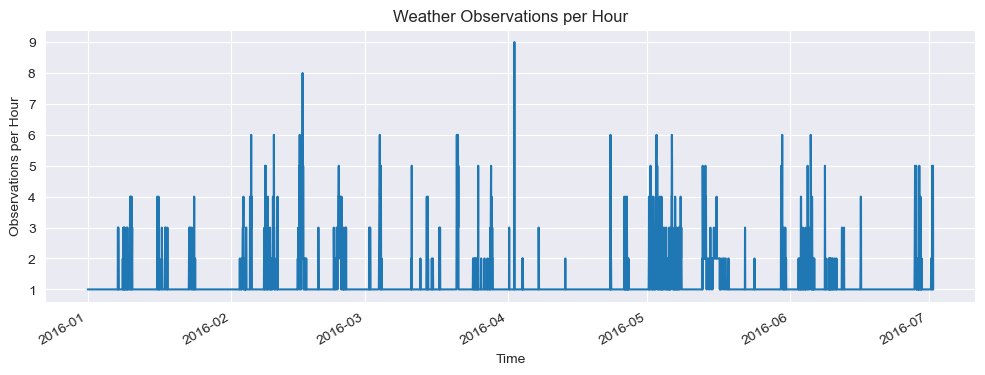

In [11]:
counts_per_hour = weather_data_raw['datetime_hour'].value_counts().sort_index()

# Plot time series frequency
plt.figure(figsize=(12, 4))
counts_per_hour.plot()
plt.title("Weather Observations per Hour")
plt.xlabel("Time")
plt.ylabel("Observations per Hour")
plt.grid(True)
plt.show()

- The timestamps are predominantly distributed hourly, with slight fluctuations.
- There are some dips in frequency; potentially missing hours.
- The data does not appear to be exactly on the hour (e.g. xx:51).

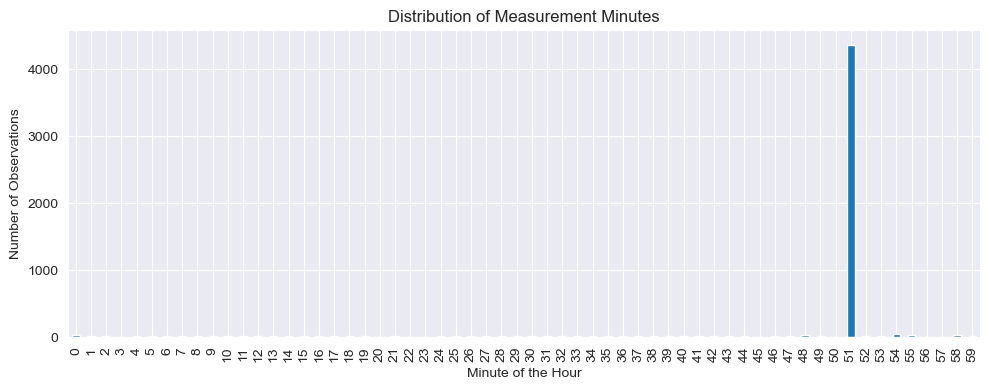

In [12]:
# Extract minute component from timestamp
weather_data_raw['datetime_minute'] = weather_data_raw['datetime'].dt.minute

# Count how many records fall into each minute of the hour
minute_distribution = weather_data_raw['datetime_minute'].value_counts().sort_index()

# Plot the distribution of measurement minutes
plt.figure(figsize=(10, 4))
minute_distribution.plot(kind='bar')
plt.title("Distribution of Measurement Minutes")
plt.xlabel("Minute of the Hour")
plt.ylabel("Number of Observations")
plt.grid(True)
plt.tight_layout()
plt.show()

- Minute 51 is by far the most frequent minute of measurement (over 4000 entries).
- All other minutes are rare or sporadic → probably exceptions, manual additions or other sources.

In [13]:
# Filter for rows measured at minute 51
weather_51 = weather_data_raw[weather_data_raw['datetime_minute'] == 51].copy()

# Count duplicated timestamps after filtering
duplicate_timestamps = weather_51['datetime'].duplicated().sum()

# Display all duplicated timestamp rows if any
duplicated_rows = weather_51[weather_51['datetime'].duplicated(keep=False)]

duplicate_timestamps, duplicated_rows.sort_values('datetime')

(np.int64(5),
                 timestamp  temp  windspeed  humidity  precip  pressure  \
 2092  2016-03-13 00:51:00  52.0        6.9      59.0     0.0     30.00   
 2093  2016-03-13 00:51:00  50.0        5.8      54.0     0.0     30.13   
 2708  2016-04-04 02:51:00  36.0        6.9      41.0     0.0     30.01   
 20    2016-04-04 02:51:00  37.0       10.0      42.0     0.0     30.02   
 2710  2016-04-04 04:51:00  37.0        9.2      46.0     0.0     29.96   
 21    2016-04-04 04:51:00  39.0        3.0      45.0     0.0     29.73   
 2932  2016-04-13 08:51:00  44.1        8.1      43.0     0.0     30.43   
 22    2016-04-13 08:51:00  45.0       12.0      42.0     0.0     30.40   
 2933  2016-04-13 09:51:00  45.0       13.8      42.0     0.0     30.43   
 23    2016-04-13 09:51:00  47.0        9.0      42.0     0.0     30.40   
 
          conditions dailyprecip dailysnow  fog  rain  snow  \
 2092          Clear           T      0.00  0.0     0     0   
 2093     Light Rain           T 

In [14]:
# Aggregate to hourly level using mean for continuous values, max for binary flags
weather_data_raw = (
  weather_51.groupby('datetime_hour')
  .agg({
    'temp': 'mean',
    'windspeed': 'mean',
    'humidity': 'mean',
    'precip': 'sum',
    'pressure': 'mean',
    'dailyprecip': 'first',  # same within a day
    'dailysnow': 'first',
    'fog': 'max',
    'rain': 'max',
    'snow': 'max',
    'conditions': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]  # most frequent
  })
  .reset_index()
)
weather_data_raw

,datetime_hour,temp,windspeed,humidity,precip,pressure,dailyprecip,dailysnow,fog,rain,snow,conditions
0,2016-01-01 00:00:00,42.1,4.6,51.0,0.00,30.06,0.00,0.00,0.0,0,0,Overcast
1,2016-01-01 01:00:00,41.0,3.5,53.0,0.00,30.06,0.00,0.00,0.0,0,0,Overcast
2,2016-01-01 02:00:00,41.0,4.6,55.0,0.00,30.06,0.00,0.00,0.0,0,0,Overcast
3,2016-01-01 03:00:00,41.0,9.2,55.0,0.00,30.06,0.00,0.00,0.0,0,0,Overcast
4,2016-01-01 04:00:00,39.9,10.4,58.0,0.00,30.04,0.00,0.00,0.0,0,0,Overcast
...,...,...,...,...,...,...,...,...,...,...,...,...
4353,2016-07-01 19:00:00,71.1,4.6,90.0,0.00,29.88,0.83,0.00,0.0,0,0,Clear
4354,2016-07-01 20:00:00,70.0,NaN,93.0,0.00,29.86,0.83,0.00,0.0,0,0,Partly Cloudy
4355,2016-07-01 21:00:00,69.1,3.5,93.0,0.00,29.89,0.83,0.00,0.0,0,0,Overcast
4356,2016-07-01 22:00:00,66.9,3.5,93.0,0.44,29.88,0.83,0.00,0.0,0,0,Scattered Clouds



- Exactly one timestamp is duplicated: 2016-03-13 00:51:00; Two different entries (Clear vs. Light
Rain), probably two weather sources or measurements.

In [15]:
weather_data_raw['hour_of_day'] = weather_data_raw['datetime_hour'].dt.hour

# Day of year and hour of year (for merging with weather)
weather_data_raw['day_of_year'] = weather_data_raw['datetime_hour'].dt.dayofyear

In [16]:
weather_data_raw['hour_of_year'] = ((weather_data_raw['day_of_year'] - 1) * 24 +
                                    weather_data_raw['hour_of_day'])
weather_data_raw.drop("day_of_year", axis=1, inplace=True)

## EDA temp

In [17]:
weather_data_raw['temp_c'] = (weather_data_raw['temp'] - 32) * 5 / 9
weather_data_raw['temp_c'].describe()

count    4358.000000
mean       10.708767
std         9.179973
min       -18.277778
25%         3.888889
50%        10.611111
75%        17.777778
max        32.222222
Name: temp_c, dtype: float64

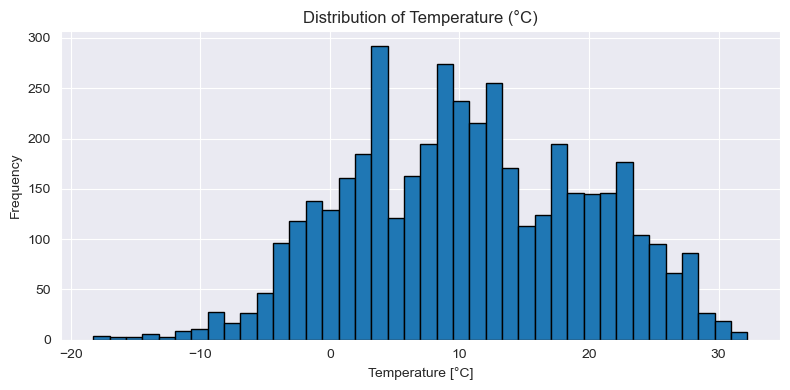

In [18]:
plt.figure(figsize=(8, 4))
weather_data_raw['temp_c'].plot.hist(bins=40, edgecolor='black')
plt.title('Distribution of Temperature (°C)')
plt.xlabel("Temperature [°C]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

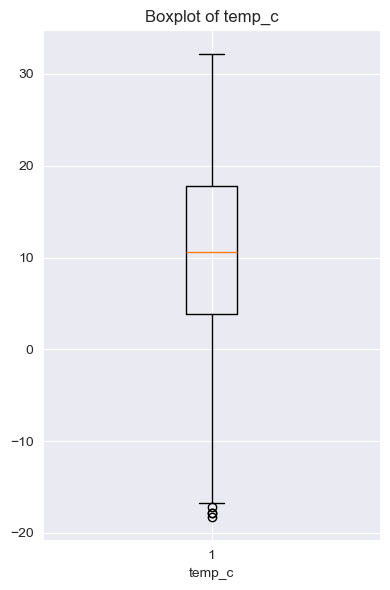

In [19]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["temp_c"].dropna())
plt.title("Boxplot of temp_c")
plt.xlabel("temp_c")
plt.tight_layout()
plt.show()

## EDA Windspeed

In [20]:
weather_data_raw['windspeed_kph'] = weather_data_raw['windspeed'] * 1.60934
weather_data_raw['windspeed_kph'].describe()

count    3469.000000
mean       11.720138
std         6.459018
min         0.000000
25%         7.402964
50%        11.104446
75%        14.805928
max       137.115768
Name: windspeed_kph, dtype: float64

In [21]:
weather_data_raw['windspeed_kph'].isna().sum()

np.int64(889)

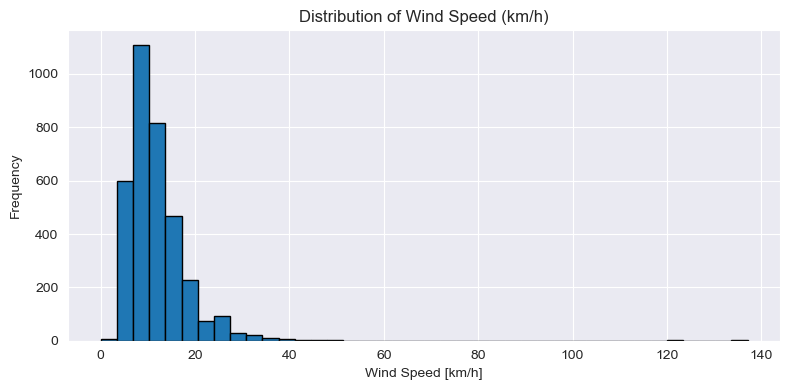

In [22]:
plt.figure(figsize=(8, 4))
weather_data_raw['windspeed_kph'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Wind Speed (km/h)")
plt.xlabel("Wind Speed [km/h]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

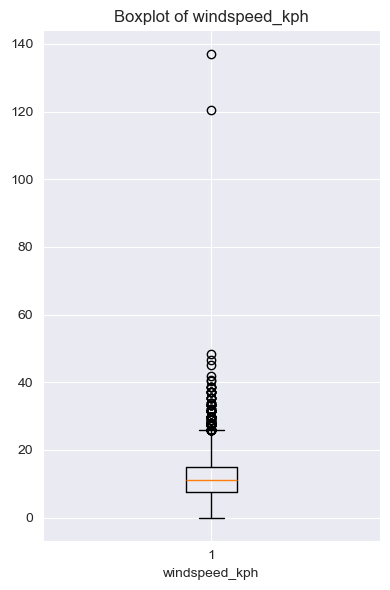

In [23]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["windspeed_kph"].dropna())
plt.title("Boxplot of windspeed_kph")
plt.xlabel("windspeed_kph")
plt.tight_layout()
plt.show()

- Most values lie between 5 and 25 km/h, which is typical for city-level weather.
- One extremely high value (137.12 km/h) may be an outlier.
- The variable appears well-behaved and usable without further transformation.

## EDA humidity

In [24]:
weather_data_raw['humidity'].describe()

count    4358.000000
mean       54.152822
std        18.985319
min         9.000000
25%        40.000000
50%        51.000000
75%        67.000000
max       100.000000
Name: humidity, dtype: float64

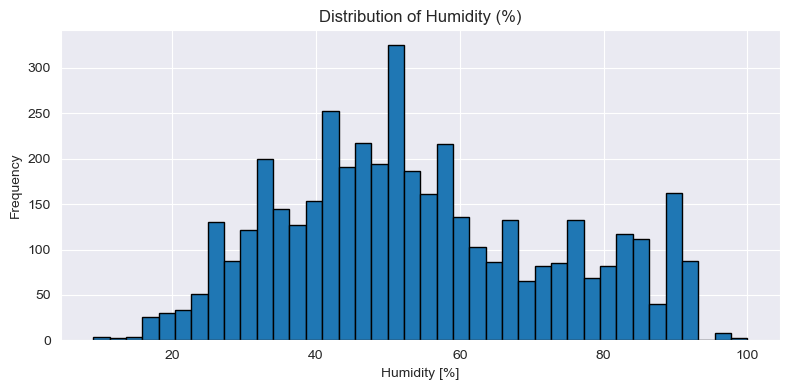

In [25]:
plt.figure(figsize=(8, 4))
weather_data_raw['humidity'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Humidity (%)")
plt.xlabel("Humidity [%]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

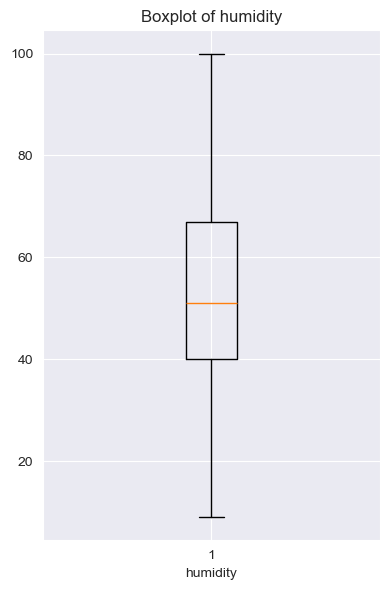

In [26]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["humidity"].dropna())
plt.title("Boxplot of humidity")
plt.xlabel("humidity")
plt.tight_layout()
plt.show()

- Values range from 9% to 97%.
- Most values lie between 40% and 70%.
- No anomalies or unrealistic entries.

## EDA precip

In [27]:
weather_data_raw['precip_mm'] = weather_data_raw['precip'] * 25.4
weather_data_raw['precip_mm'].describe()

count    4358.000000
mean        0.110214
std         0.725522
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        18.542000
Name: precip_mm, dtype: float64

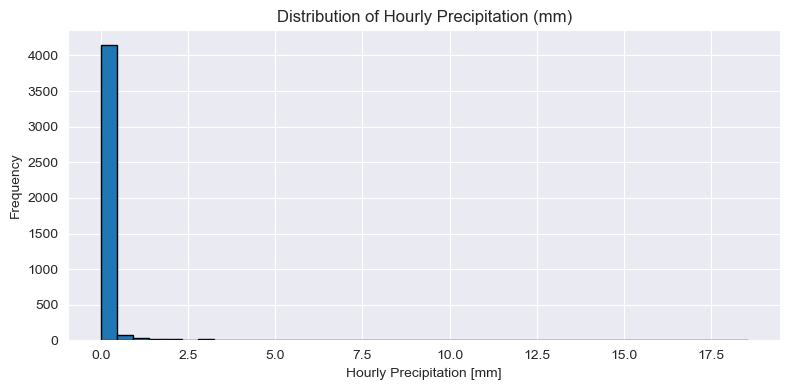

In [28]:
plt.figure(figsize=(8, 4))
weather_data_raw['precip_mm'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Hourly Precipitation (mm)")
plt.xlabel("Hourly Precipitation [mm]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

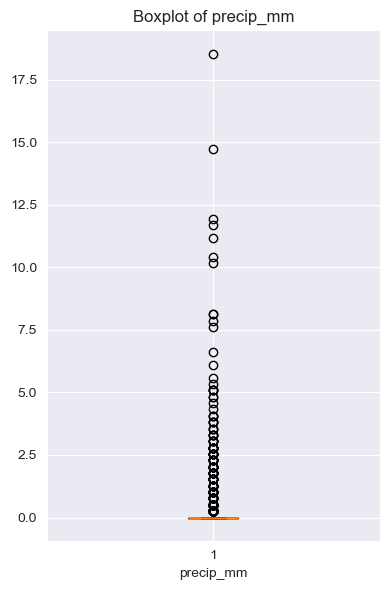

In [29]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["precip_mm"].dropna())
plt.title("Boxplot of precip_mm")
plt.xlabel("precip_mm")
plt.tight_layout()
plt.show()

Findings of the Exploration
- Most values are 0.0 (dry hours).
- Occasional rain events up to 18.5 mm.

Required Arrangements
- None. Consider binary flag creation (e.g. had_rain = precip_mm > 0).

## EDA pressure

In [30]:
weather_data_raw['pressure_hPa'] = weather_data_raw['pressure'] * 33.8639
weather_data_raw['pressure_hPa'].describe()

count    4338.000000
mean     1015.565442
std         7.941241
min       989.503158
25%      1010.160137
50%      1015.917000
75%      1020.657946
max      1036.912618
Name: pressure_hPa, dtype: float64

In [31]:
weather_data_raw['pressure_hPa'].isna().sum()

np.int64(20)

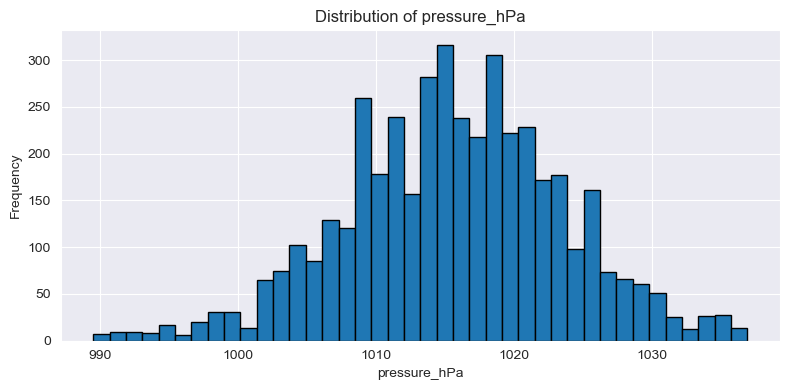

In [32]:
plt.figure(figsize=(8, 4))
weather_data_raw['pressure_hPa'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of pressure_hPa")
plt.xlabel("pressure_hPa")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

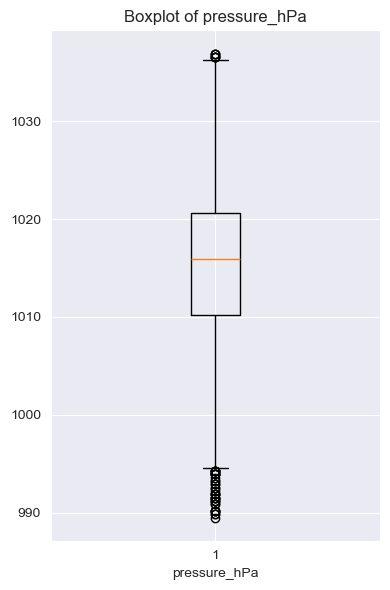

In [33]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["pressure_hPa"].dropna())
plt.title("Boxplot of pressure_hPa")
plt.xlabel("pressure_hPa")
plt.tight_layout()
plt.show()

## EDA dailyrain

In [34]:
weather_data_raw['dailyprecip'].value_counts()

dailyprecip
0.00    2466
T        426
0.01     185
0.05      96
0.04      96
0.09      94
0.02      72
0.16      72
0.0       65
0.24      48
0.45      48
0.06      48
0.20      24
0.61      24
0.5       24
0.54      24
0.12      24
0.18      24
0.40      24
0.91      24
0.22      24
1.65      24
0.29      24
0.38      24
0.07      24
0.14      24
1.22      24
0.30      24
0.03      24
1.01      24
0.53      24
0.73      24
2.31      24
1.80      24
0.83      24
0.47      23
0.11      23
0.44      23
0.15      21
Name: count, dtype: int64

In [35]:
# Ersetze 'T' durch einen minimalen Wert
weather_data_raw['dailyprecip'] = weather_data_raw['dailyprecip'].replace('T', '0.001')

In [36]:
weather_data_raw['dailyprecip'] = weather_data_raw['dailyprecip'].astype(float)

In [37]:
weather_data_raw['precip_daily_mm'] = weather_data_raw['dailyprecip'] * 25.4

In [38]:
weather_data_raw['precip_daily_mm'].isna().sum()

np.int64(0)

In [39]:
weather_data_raw['precip_daily_mm'].describe()

count    4358.000000
mean        2.647393
std         7.727016
min         0.000000
25%         0.000000
50%         0.000000
75%         1.016000
max        58.674000
Name: precip_daily_mm, dtype: float64

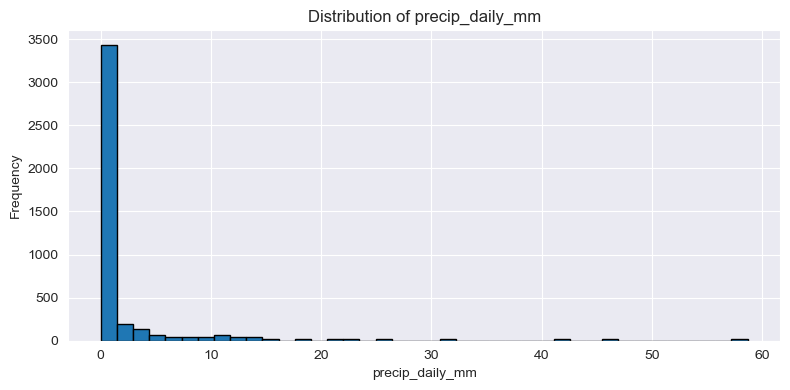

In [40]:
plt.figure(figsize=(8, 4))
weather_data_raw['precip_daily_mm'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of precip_daily_mm")
plt.xlabel("precip_daily_mm")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

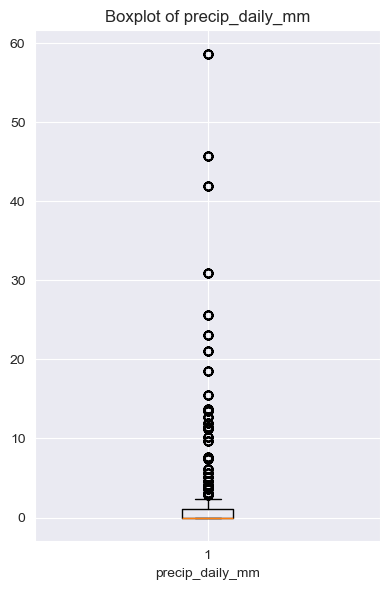

In [41]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["precip_daily_mm"].dropna())
plt.title("Boxplot of precip_daily_mm")
plt.xlabel("precip_daily_mm")
plt.tight_layout()
plt.show()

- ...

## EDA dailysnow

In [42]:
weather_data_raw['dailysnow'].value_counts()

dailysnow
0.00     3771
T         285
0.0       112
0.40       47
0.20       24
26.60      24
2.50       24
0.10       24
0.50       24
1.40       23
Name: count, dtype: int64

In [43]:
weather_data_raw['dailysnow'] = weather_data_raw['dailysnow'].replace('T', '0.001')
weather_data_raw['dailysnow'] = weather_data_raw['dailysnow'].astype(float)

In [44]:
weather_data_raw['daily_snow_mm'] = weather_data_raw['dailysnow'] * 25.4
weather_data_raw['daily_snow_mm'].describe()

count    4358.000000
mean        4.481340
std        50.254303
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       675.640000
Name: daily_snow_mm, dtype: float64

In [45]:
weather_data_raw['daily_snow_mm'].isna().sum()

np.int64(0)

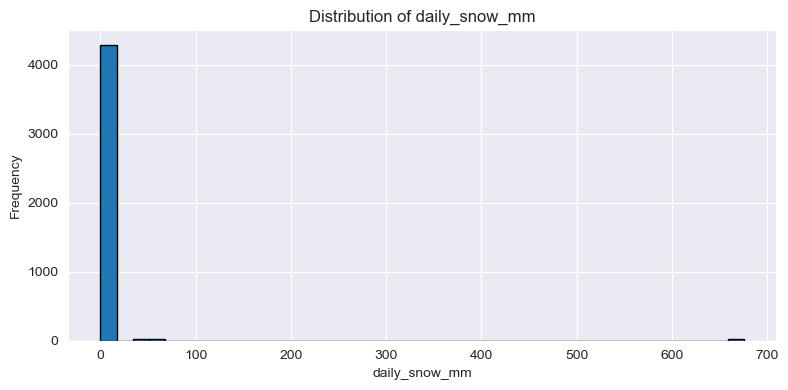

In [46]:
plt.figure(figsize=(8, 4))
weather_data_raw['daily_snow_mm'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of daily_snow_mm")
plt.xlabel("daily_snow_mm")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

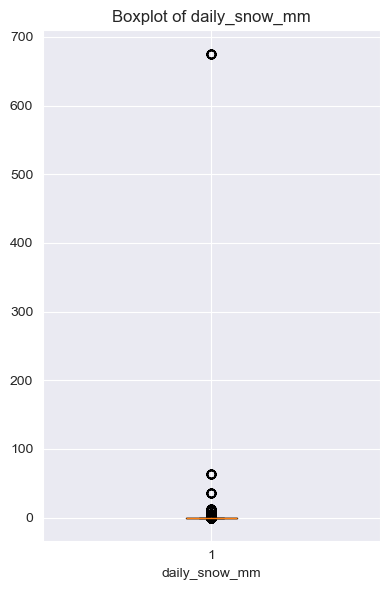

In [47]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["daily_snow_mm"].dropna())
plt.title("Boxplot of daily_snow_mm")
plt.xlabel("daily_snow_mm")
plt.tight_layout()
plt.show()

EDA fog, rain, snow

In [48]:
weather_data_raw['fog'].value_counts()

fog
0.0    4219
1.0      27
Name: count, dtype: int64

In [49]:
weather_data_raw['rain'].value_counts()

rain
0    4165
1     193
Name: count, dtype: int64

In [50]:
weather_data_raw['snow'].value_counts()

snow
0    4290
1      68
Name: count, dtype: int64

## EDA Conditions

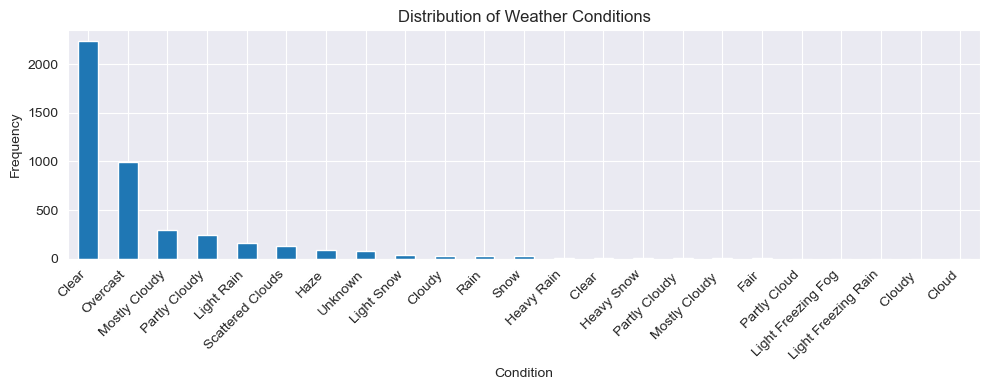

In [51]:
condition_counts = weather_data_raw['conditions'].value_counts()

plt.figure(figsize=(10, 4))
condition_counts.plot(kind='bar')
plt.title("Distribution of Weather Conditions")
plt.xlabel("Condition")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

- Most common condition is Clear (2215 times), followed by Overcast (1000).
- Some conditions occur only a few times, e.g., Heavy Snow, Light Freezing Fog.
- Unknown appears 83 times and may indicate missing or invalid sensor data.

# Classify / EDA  Weather Conditions

## Classify / EDA –  rain intensity

In [52]:
# 1. Human-readable rain classification
def classify_rain_label(x):
  if x >= 30:
    return 'extreme_rain'
  elif x >= 15:
    return 'very_heavy_rain'
  elif x >= 7.5:
    return 'heavy_rain'
  elif x >= 2.5:
    return 'moderate_rain'
  elif x > 0:
    return 'light_rain'
  else:
    return 'no_rain'


weather_data_raw['rain_class'] = weather_data_raw['precip_mm'].apply(classify_rain_label)

In [53]:

# 2. Ordinal encoding for machine learning
rain_mapping = {
  'no_rain': 0,
  'light_rain': 1,
  'moderate_rain': 2,
  'heavy_rain': 3,
  'very_heavy_rain': 4,
  'extreme_rain': 5
}

weather_data_raw['rain_code'] = weather_data_raw['rain_class'].map(rain_mapping)

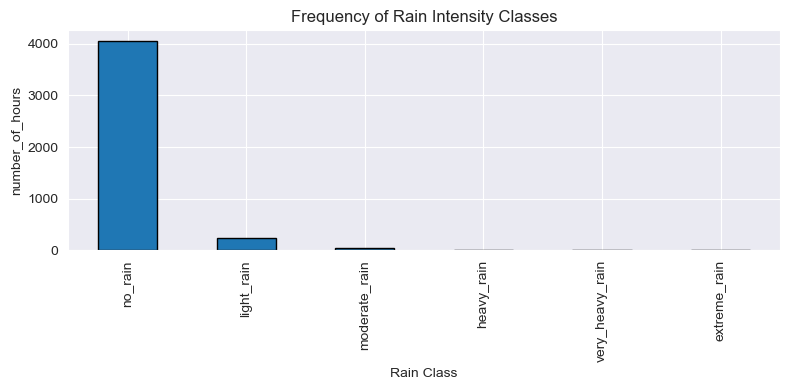

In [54]:
rain_counts = weather_data_raw['rain_class'].value_counts().reindex([
  'no_rain', 'light_rain', 'moderate_rain', 'heavy_rain', 'very_heavy_rain', 'extreme_rain'
])

rain_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Rain Intensity Classes")
plt.xlabel("Rain Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

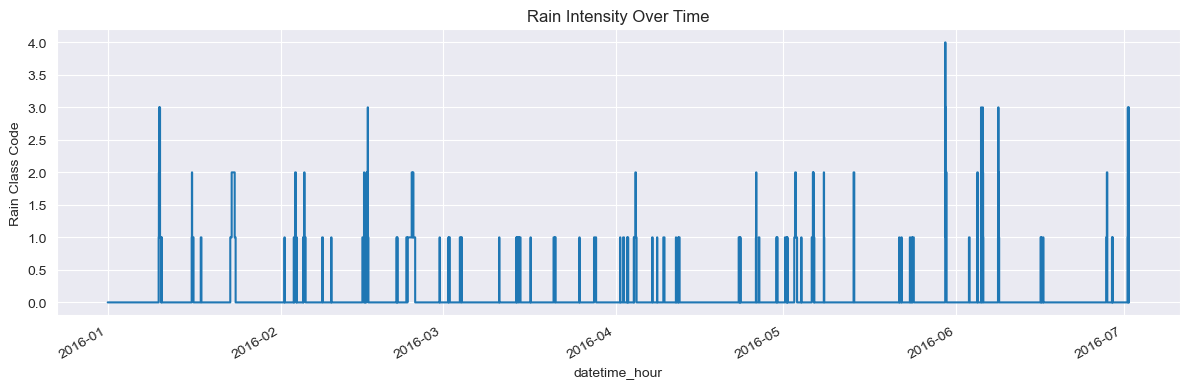

In [55]:
rain_time_series = weather_data_raw.set_index('datetime_hour')['rain_code']

plt.figure(figsize=(12, 4))
rain_time_series.plot(drawstyle='steps-post')
plt.title("Rain Intensity Over Time")
plt.ylabel("Rain Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

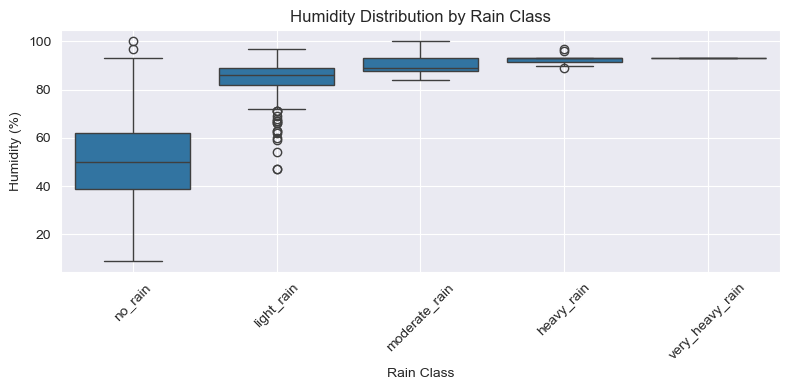

In [56]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=weather_data_raw, x='rain_class', y='humidity')
plt.title("Humidity Distribution by Rain Class")
plt.xlabel("Rain Class")
plt.ylabel("Humidity (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA – snow intensity

In [57]:
# 1. Human-readable snow classification based on conditions
def classify_snow_label(x):
  if x == "Light Snow":
    return 'light_snow'
  elif x == "Snow":
    return "snow"
  elif x == "Heavy Snow":
    return 'heavy_snow'
  else:
    return 'no_snow'


weather_data_raw['snow_class'] = weather_data_raw['conditions'].apply(classify_snow_label)

In [58]:
# 2. Ordinal encoding for ML
snow_mapping = {
  'no_snow': 0,
  'light_snow': 1,
  "snow": 2,
  'heavy_snow': 3
}

weather_data_raw['snow_code'] = weather_data_raw['snow_class'].map(snow_mapping)

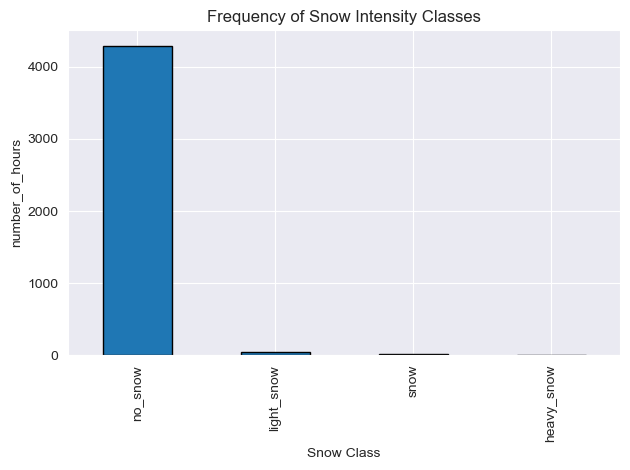

In [59]:
weather_data_raw['snow_class'].value_counts().reindex([
  'no_snow', 'light_snow', "snow", 'heavy_snow'
]).plot(kind='bar', edgecolor='black')
plt.title("Frequency of Snow Intensity Classes")
plt.xlabel("Snow Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

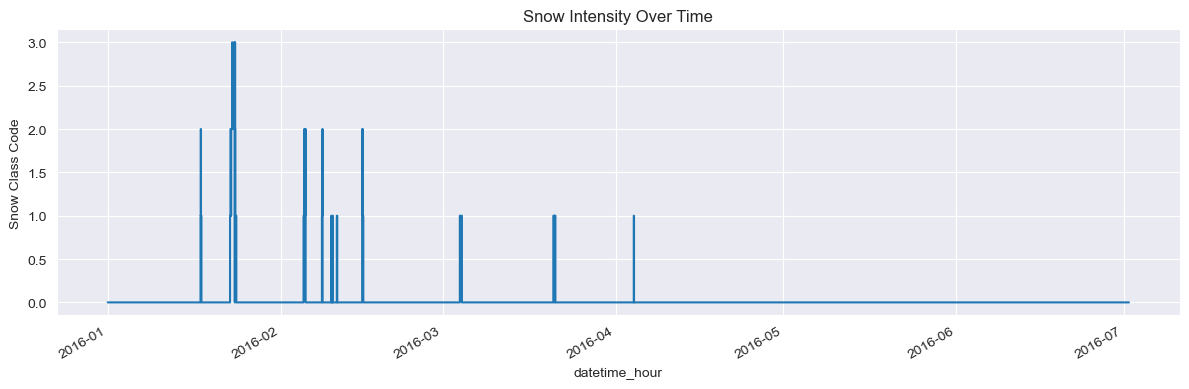

In [60]:
# Time series: Snow Class Code
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['snow_code'].plot(drawstyle='steps-post')
plt.title("Snow Intensity Over Time")
plt.ylabel("Snow Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  cloud intensity

In [61]:
# 1. Human-readable cloud classification based on conditions
def classify_cloud_label(x):
  if x == "Clear":
    return "clear"  # 0–10%
  elif x == "Scattered Clouds":
    return 'scattered_clouds'  # ~25–50%
  elif x == "Partly Cloudy":
    return 'partly_cloudy'  # ~20–60%
  elif x == "Mostly Cloudy":
    return 'mostly_cloudy'  # ~60–90%
  elif x == "Overcast":
    return "overcast"  # >90%
  else:
    return "unknown"


weather_data_raw['cloud_class'] = weather_data_raw['conditions'].apply(classify_cloud_label)

In [62]:

# 2. Ordinal encoding for ML
cloud_mapping = {
  "unknown": 0,
  "clear": 1,
  'scattered_clouds': 2,
  'partly_cloudy': 3,
  'mostly_cloudy': 4,
  "overcast": 5
}

weather_data_raw['cloud_code'] = weather_data_raw['cloud_class'].map(cloud_mapping)

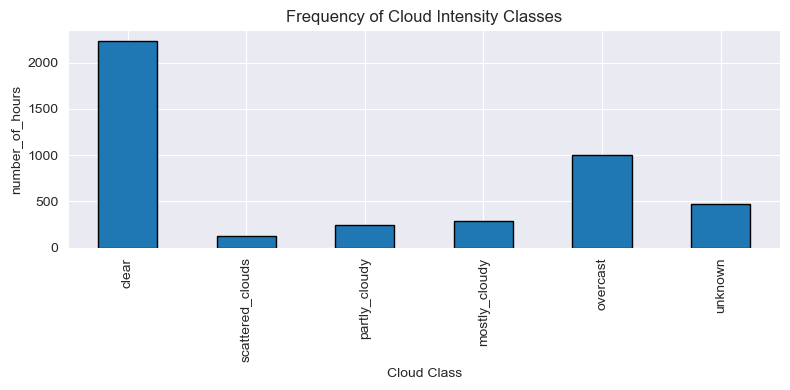

In [63]:
# Bar plot: Frequency of Cloud Classes
cloud_counts = weather_data_raw['cloud_class'].value_counts().reindex([
  "clear", 'scattered_clouds', 'partly_cloudy', 'mostly_cloudy', "overcast", "unknown"
])
cloud_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Cloud Intensity Classes")
plt.xlabel("Cloud Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

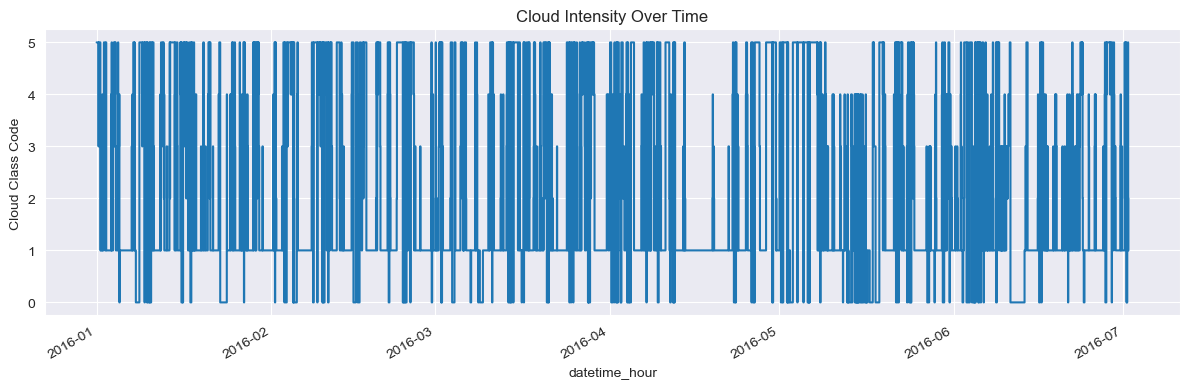

In [64]:
# Time series: Cloud Class Code
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['cloud_code'].plot(drawstyle='steps-post')
plt.title("Cloud Intensity Over Time")
plt.ylabel("Cloud Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Humidity by Cloud Class')

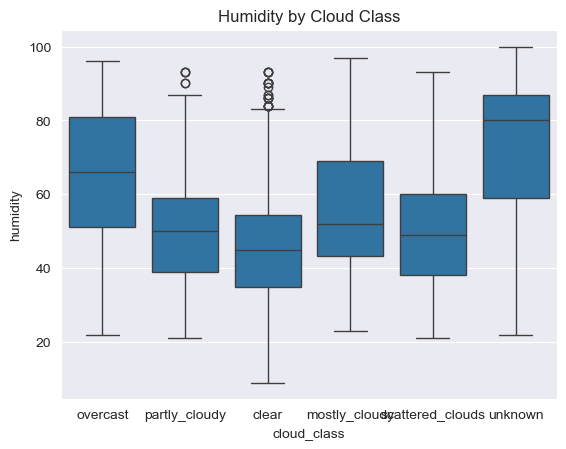

In [65]:
sns.boxplot(data=weather_data_raw, x='cloud_class', y='humidity')
plt.title("Humidity by Cloud Class")

## Classify / EDA –  haze intensity

In [66]:
NO_HAZE = 'no_haze'

In [67]:
# 1. Human-readable haze classification
def classify_haze_label(x):
  return "haze" if x == "Haze" else 'no_haze'


weather_data_raw['hazy_class'] = weather_data_raw['conditions'].apply(classify_haze_label)

In [68]:

# 2. Binary encoding for ML
haze_mapping = {
  'no_haze': 0,
  "haze": 1
}

weather_data_raw['hazy_code'] = weather_data_raw['hazy_class'].map(haze_mapping)

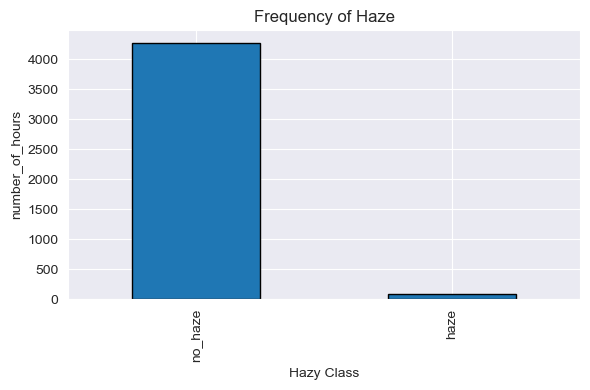

In [69]:
# Bar plot: Frequency of Haze
hazy_counts = weather_data_raw['hazy_class'].value_counts().reindex([NO_HAZE, "haze"])
hazy_counts.plot(kind='bar', edgecolor='black', figsize=(6, 4))
plt.title("Frequency of Haze")
plt.xlabel("Hazy Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

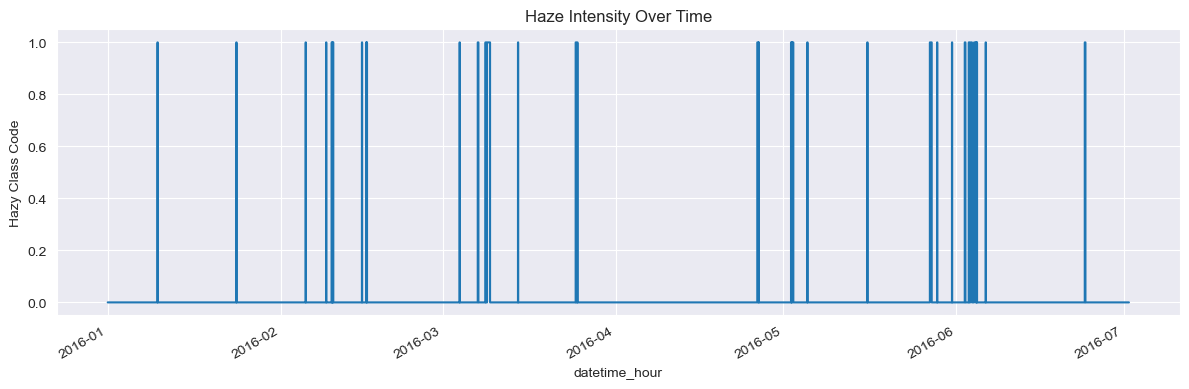

In [70]:
# Time series: Hazy Class Code
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['hazy_code'].plot(drawstyle='steps-post')
plt.title("Haze Intensity Over Time")
plt.ylabel("Hazy Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  freezing fog or rain

In [71]:
# 1. Human-readable freezing condition classification
def classify_freezing_label(x):
  if x == "Light Freezing Fog":
    return 'light_freezing_fog'
  elif x == "Light Freezing Rain":
    return 'light_freezing_rain'
  else:
    return "none"


weather_data_raw['freezing_class'] = weather_data_raw['conditions'].apply(classify_freezing_label)

In [72]:


# 2. Ordinal encoding for ML
freezing_mapping = {
  "none": 0,
  'light_freezing_rain': 1,
  'light_freezing_fog': 2
}

weather_data_raw['freezing_code'] = weather_data_raw['freezing_class'].map(freezing_mapping)

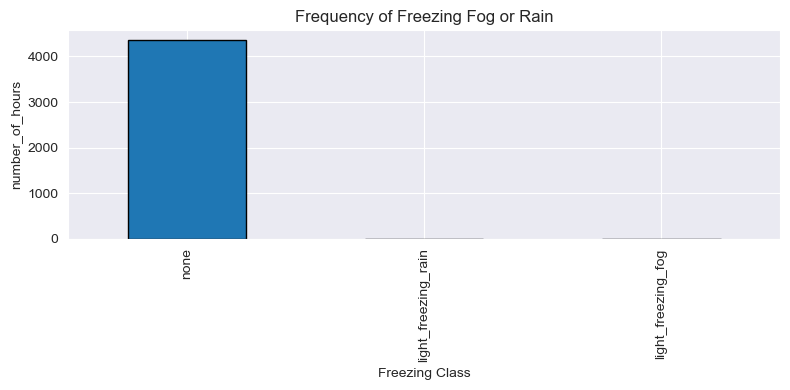

In [73]:
# Bar plot: Frequency of Freezing Classes
freezing_counts = weather_data_raw['freezing_class'].value_counts().reindex([
  "none", 'light_freezing_rain', 'light_freezing_fog'
])
freezing_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Freezing Fog or Rain")
plt.xlabel("Freezing Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

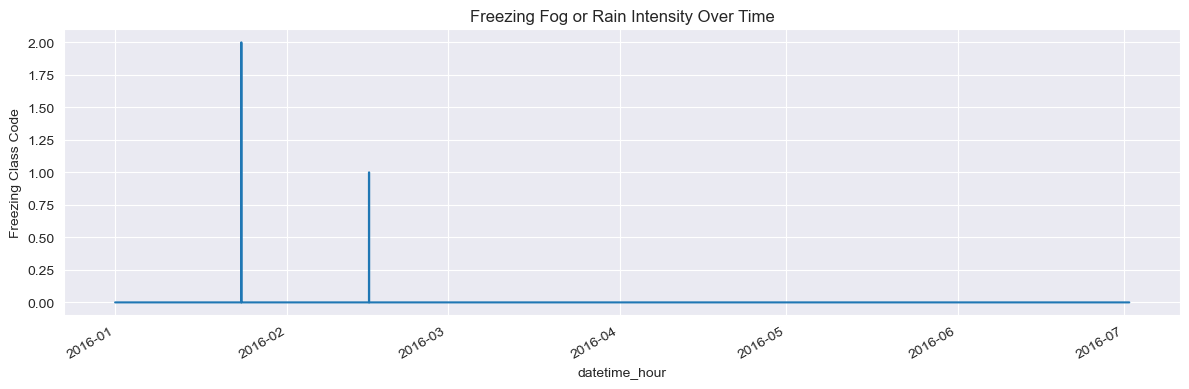

In [74]:
# Time series: Freezing Class Code
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['freezing_code'].plot(drawstyle='steps-post')
plt.title("Freezing Fog or Rain Intensity Over Time")
plt.ylabel("Freezing Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  fog

In [75]:
# 1. Human-readable fog classification
def classify_fog_label(x):
  if x == 1:
    return "fog"
  elif x == 0:
    return 'no_fog'
  return None


weather_data_raw['fog_class'] = weather_data_raw['fog'].apply(classify_fog_label)

In [76]:
# 2. Binary encoding for ML
fog_mapping = {
  "fog": 1,
  "no_fog": 0
}

weather_data_raw['fog_code'] = weather_data_raw['fog_class'].map(fog_mapping)

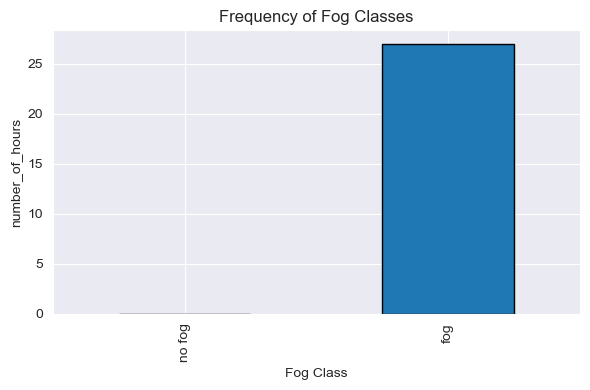

In [77]:
# Bar plot: Frequency of Fog Classes
fog_counts = weather_data_raw['fog_class'].value_counts().reindex(["no fog", "fog"])
fog_counts.plot(kind='bar', edgecolor='black', figsize=(6, 4))
plt.title("Frequency of Fog Classes")
plt.xlabel("Fog Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

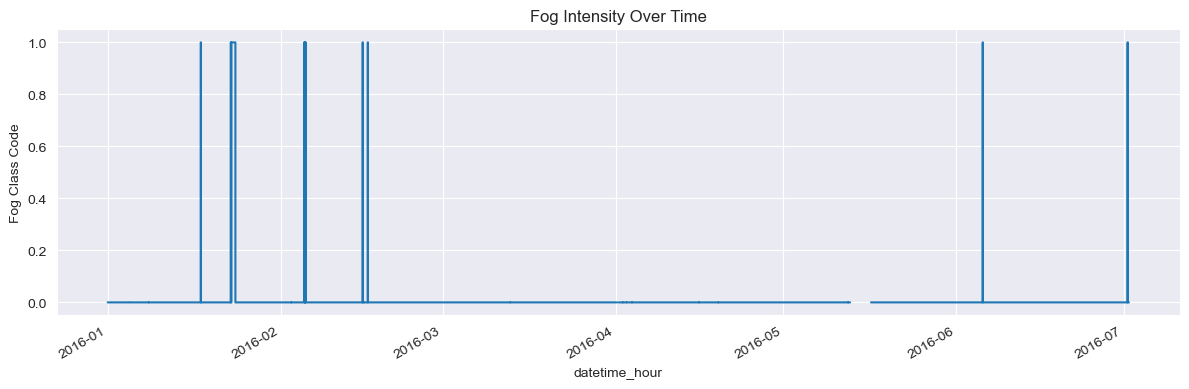

In [78]:
# Time series: Fog Class Code
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['fog_code'].plot(drawstyle='steps-post')
plt.title("Fog Intensity Over Time")
plt.ylabel("Fog Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  temp itensity

In [79]:
# 1. Human-readable temperature classification
def classify_temp_label(t):
  if t < -5:
    return 'very_cold'
  elif t < 5:
    return "cold"
  elif t < 15:
    return "cool"
  elif t < 20:
    return "mild"
  elif t < 25:
    return "warm"
  else:
    return "hot"


weather_data_raw['temp_class'] = weather_data_raw['temp_c'].apply(classify_temp_label)

In [80]:
# 2. Ordinal encoding for ML
temp_mapping = {
  'very_cold': 0,
  "cold": 1,
  "cool": 2,
  "mild": 3,
  "warm": 4,
  "hot": 5
}

weather_data_raw['temp_code'] = weather_data_raw['temp_class'].map(temp_mapping)

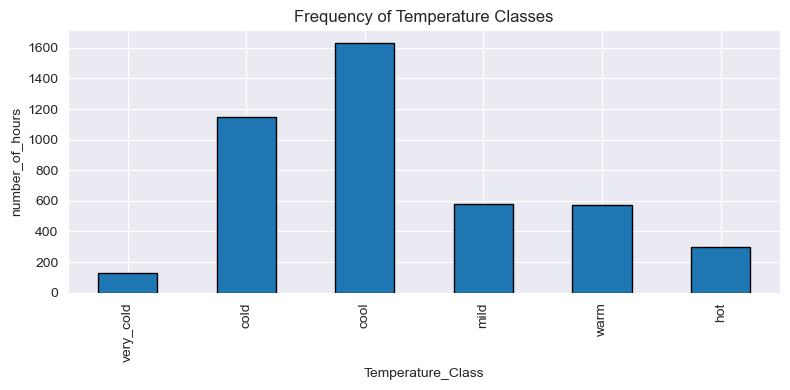

In [81]:
# Bar plot: Frequency of Temperature Classes
temp_counts = weather_data_raw['temp_class'].value_counts().reindex([
  'very_cold', "cold", "cool", "mild", "warm", "hot"
])

temp_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Temperature Classes")
plt.xlabel('Temperature_Class')
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

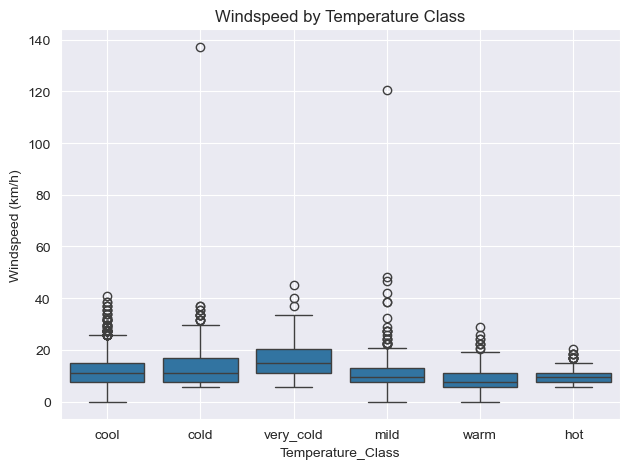

In [82]:
# Boxplot: Windspeed by Temperature Class
sns.boxplot(data=weather_data_raw, x='temp_class', y='windspeed_kph')
plt.title("Windspeed by Temperature Class")
plt.xlabel('Temperature_Class')
plt.ylabel("Windspeed (km/h)")
plt.grid(True)
plt.tight_layout()
plt.show()

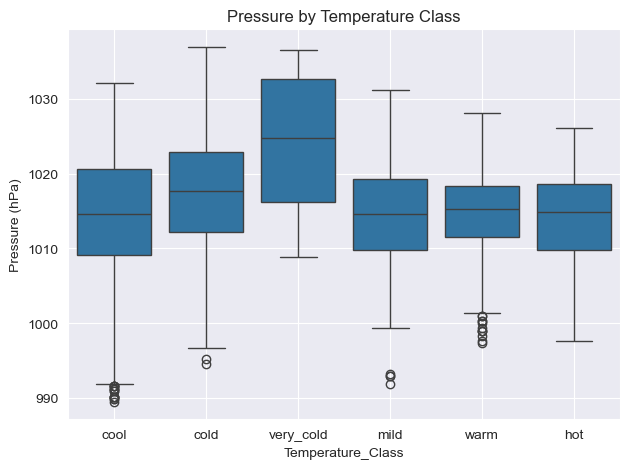

In [83]:
# Boxplot: Pressure by Temperature Class
sns.boxplot(data=weather_data_raw, x='temp_class', y='pressure_hPa')
plt.title("Pressure by Temperature Class")
plt.xlabel('Temperature_Class')
plt.ylabel("Pressure (hPa)")
plt.grid(True)
plt.tight_layout()
plt.show()

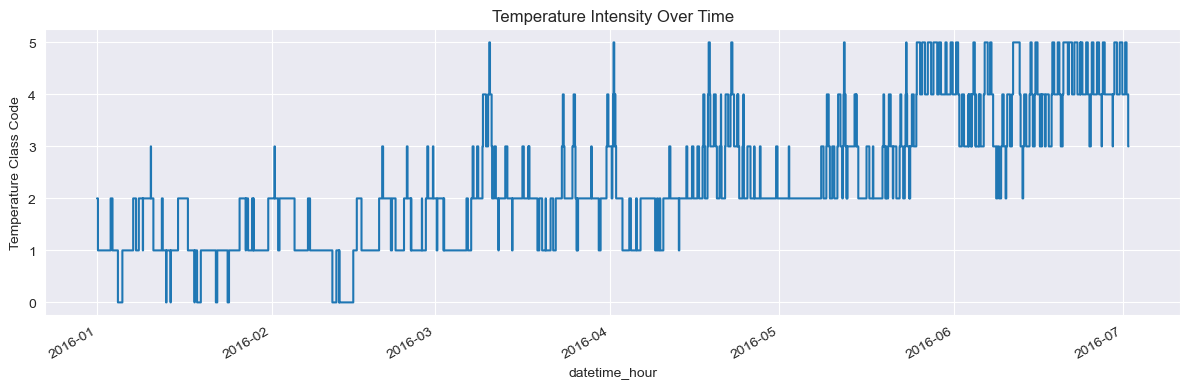

In [84]:
# Time series: Temperature Class Code over Time
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['temp_code'].plot(drawstyle='steps-post')
plt.title("Temperature Intensity Over Time")
plt.ylabel("Temperature Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  windspeed itensity

In [85]:
# 1. Human-readable windspeed classification (Beaufort-based)
def classify_wind_label(speed):
  if speed < 1:
    return "calm"
  elif speed < 12:
    return 'light_air'
  elif speed < 29:
    return 'light_breeze'
  elif speed < 50:
    return 'moderate_breeze'
  elif speed < 75:
    return 'strong_breeze'
  else:
    return "stormy"


weather_data_raw['windspeed_class'] = weather_data_raw['windspeed_kph'].apply(classify_wind_label)

In [86]:
# 2. Ordinal encoding for ML
windspeed_mapping = {
  "calm": 0,
  'light_air': 1,
  'light_breeze': 2,
  'moderate_breeze': 3,
  'strong_breeze': 4,
  "stormy": 5
}

weather_data_raw['windspeed_code'] = weather_data_raw['windspeed_class'].map(
    windspeed_mapping)

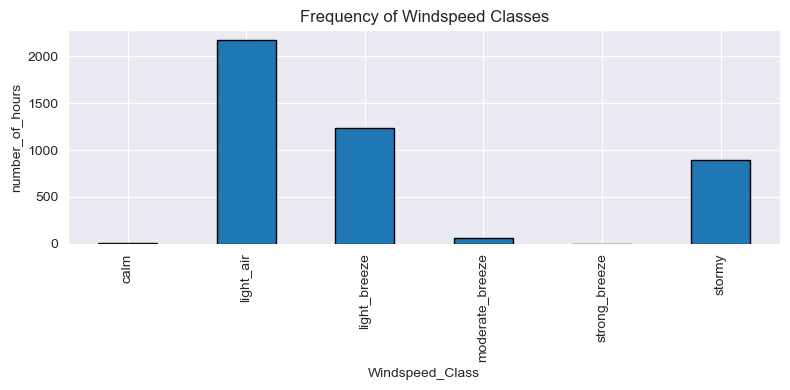

In [87]:
# Bar plot: Frequency of Windspeed Classes
windspeed_counts = weather_data_raw['windspeed_class'].value_counts().reindex([
  "calm", 'light_air', 'light_breeze', 'moderate_breeze', 'strong_breeze', "stormy"
])

windspeed_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Windspeed Classes")
plt.xlabel('Windspeed_Class')
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

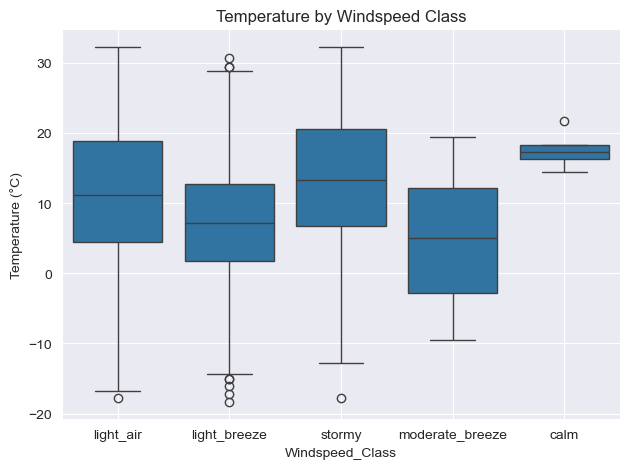

In [88]:
# Boxplot: Temperature by Windspeed Class
sns.boxplot(data=weather_data_raw, x='windspeed_class', y='temp_c')
plt.title("Temperature by Windspeed Class")
plt.xlabel('Windspeed_Class')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

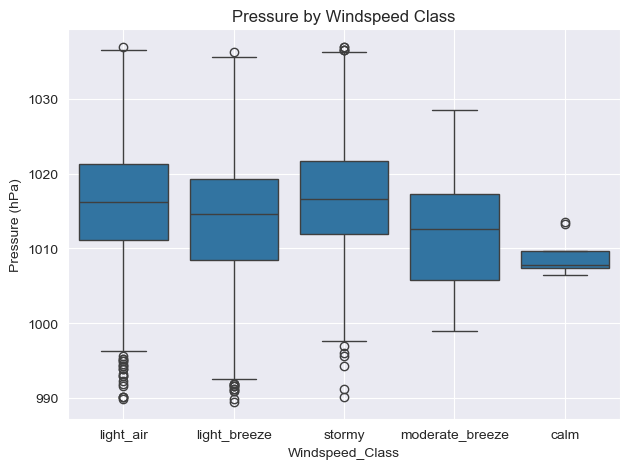

In [89]:
# Boxplot: Pressure by Windspeed Class
sns.boxplot(data=weather_data_raw, x='windspeed_class', y='pressure_hPa')
plt.title("Pressure by Windspeed Class")
plt.xlabel('Windspeed_Class')
plt.ylabel("Pressure (hPa)")
plt.grid(True)
plt.tight_layout()
plt.show()

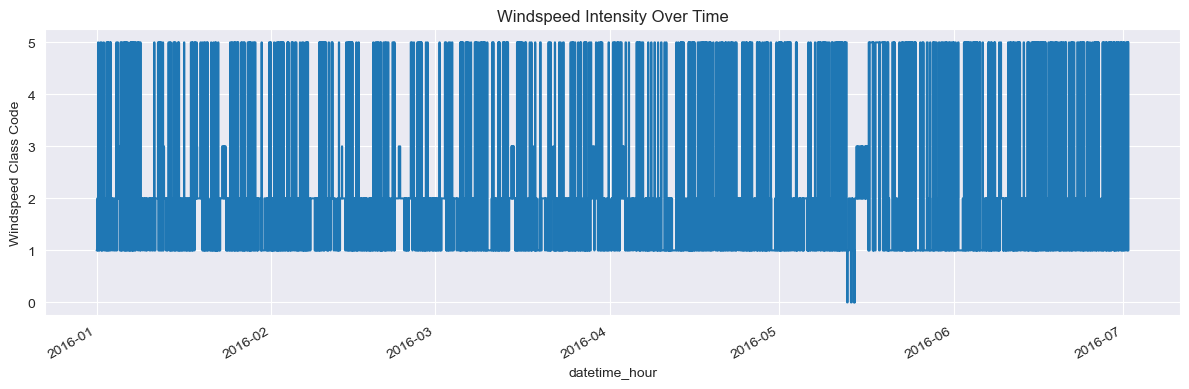

In [90]:
# Time series: Windspeed Class Code over Time
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['windspeed_code'].plot(drawstyle='steps-post')
plt.title("Windspeed Intensity Over Time")
plt.ylabel("Windspeed Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  humidity itensity

In [91]:
def classify_humidity(h):
  if h <= 30:
    return 'very_dry'
  elif h <= 50:
    return 'dry'
  elif h <= 70:
    return 'normal'
  elif h <= 85:
    return 'wet'
  else:
    return 'very_wet'


weather_data_raw['humidity_class'] = weather_data_raw['humidity'].apply(classify_humidity)

In [92]:
humidity_mapping = {
  'very_dry': 0,
  'dry': 1,
  'normal': 2,
  'wet': 3,
  'very_wet': 4
}
weather_data_raw['humidity_code'] = weather_data_raw['humidity_class'].map(humidity_mapping)

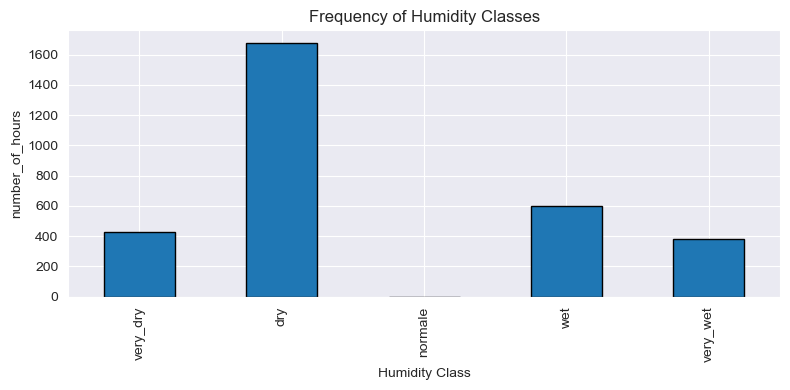

In [93]:
# Bar plot: Frequency of Humidity Classes
humidity_counts = weather_data_raw['humidity_class'].value_counts().reindex([
  'very_dry', 'dry', 'normale', 'wet', 'very_wet'
])

humidity_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Humidity Classes")
plt.xlabel("Humidity Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

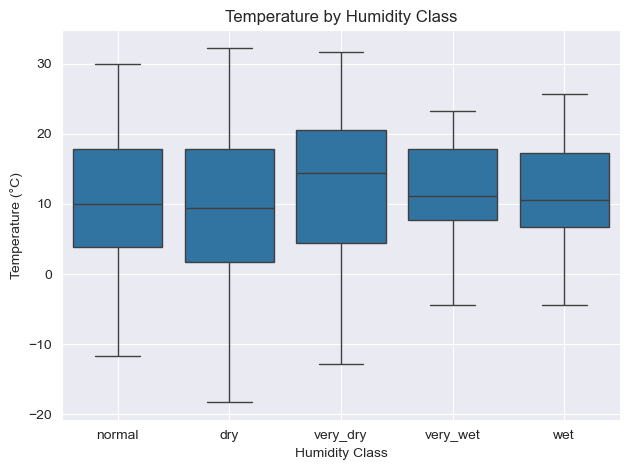

In [94]:

# Boxplot: Temperature by Humidity Class
sns.boxplot(data=weather_data_raw, x='humidity_class', y='temp_c')
plt.title("Temperature by Humidity Class")
plt.xlabel("Humidity Class")
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

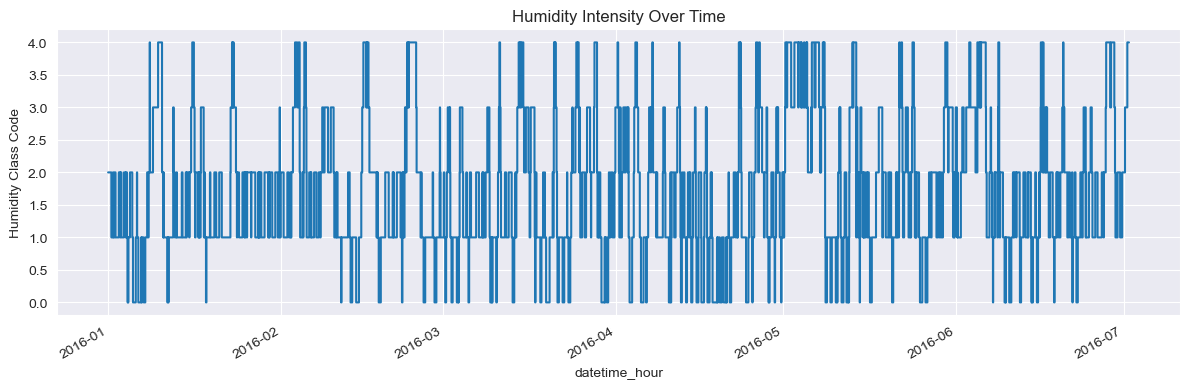

In [95]:

# Time series: Humidity Class Code over Time
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['humidity_code'].plot(drawstyle='steps-post')
plt.title("Humidity Intensity Over Time")
plt.ylabel("Humidity Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classify / EDA –  pressure itensity

In [96]:
def classify_pressure_label(p):
  if p < 980:
    return 'very_low'
  elif p < 1000:
    return "low"
  elif p < 1020:
    return "normal"
  elif p < 1030:
    return "high"
  else:
    return 'very_high'


weather_data_raw['pressure_class'] = weather_data_raw['pressure_hPa'].apply(classify_pressure_label)

In [97]:

pressure_mapping = {
  'very_low': 0,
  "low": 1,
  "normal": 2,
  "high": 3,
  'very_high': 4
}

weather_data_raw['pressure_code'] = weather_data_raw['pressure_class'].map(pressure_mapping)

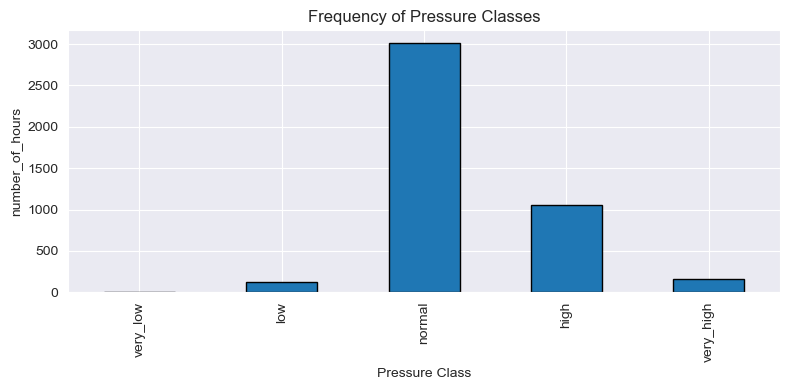

In [98]:
# Bar plot: Frequency of Pressure Classes
pressure_counts = weather_data_raw['pressure_class'].value_counts().reindex([
  'very_low', "low", "normal", "high", 'very_high'
])

pressure_counts.plot(kind='bar', edgecolor='black', figsize=(8, 4))
plt.title("Frequency of Pressure Classes")
plt.xlabel("Pressure Class")
plt.ylabel('number_of_hours')
plt.grid(True)
plt.tight_layout()
plt.show()

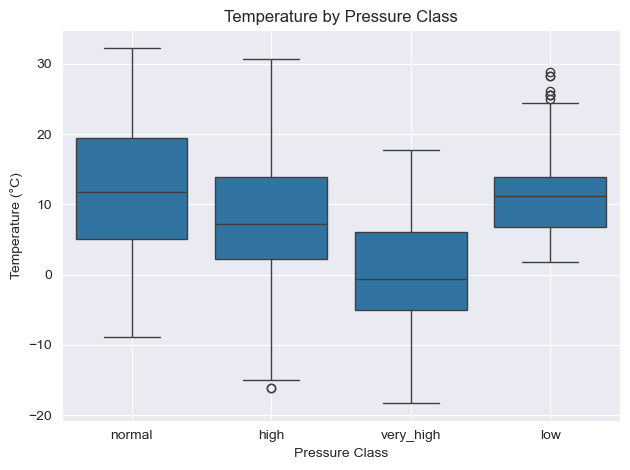

In [99]:

# Boxplot: Temperature by Pressure Class
sns.boxplot(data=weather_data_raw, x='pressure_class', y='temp_c')
plt.title("Temperature by Pressure Class")
plt.xlabel("Pressure Class")
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

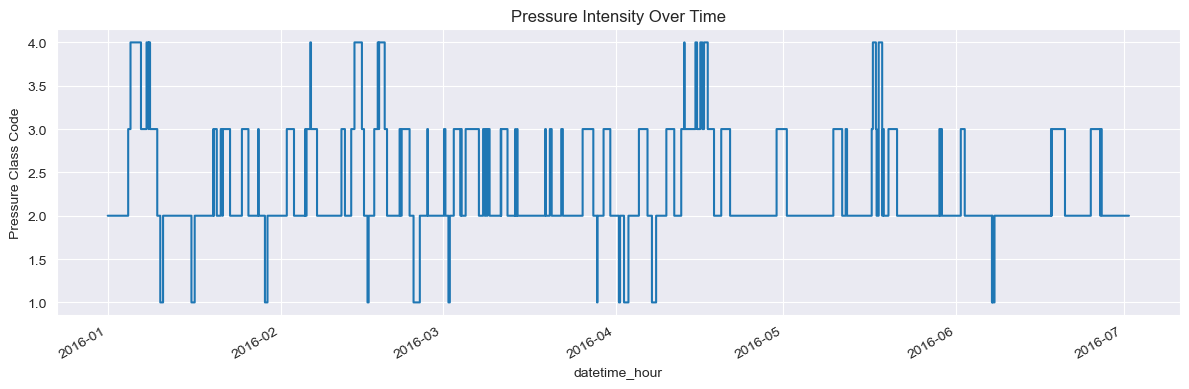

In [100]:

# Time series: Pressure Class Code over Time
plt.figure(figsize=(12, 4))
weather_data_raw.set_index('datetime_hour')['pressure_code'].plot(drawstyle='steps-post')
plt.title("Pressure Intensity Over Time")
plt.ylabel("Pressure Class Code")
plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
weather_data_raw.isna().sum()

datetime_hour        0
temp                 0
windspeed          889
humidity             0
precip               0
pressure            20
dailyprecip          0
dailysnow            0
fog                112
rain                 0
snow                 0
conditions           0
hour_of_day          0
hour_of_year         0
temp_c               0
windspeed_kph      889
precip_mm            0
pressure_hPa        20
precip_daily_mm      0
daily_snow_mm        0
rain_class           0
rain_code            0
snow_class           0
snow_code            0
cloud_class          0
cloud_code           0
hazy_class           0
hazy_code            0
freezing_class       0
freezing_code        0
fog_class          112
fog_code           112
temp_class           0
temp_code            0
windspeed_class      0
windspeed_code       0
humidity_class       0
humidity_code        0
pressure_class       0
pressure_code        0
dtype: int64

# Imputation

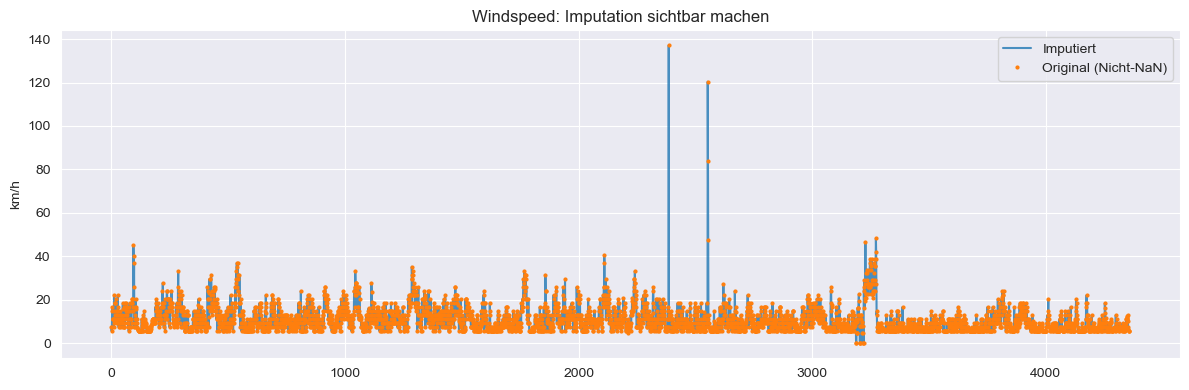

mean before: 11.049764820076625
mean after: 11.049764820076625
std deviation before: 6.20441283859607
std deviation after: 6.20441283859607


In [102]:
weather_data_before_imputation = weather_data_raw
weather_data_raw.set_index('datetime_hour', inplace=True)
weather_data_raw['windspeed_kph'] = weather_data_raw['windspeed_kph'].interpolate(method='time')

weather_data_raw.reset_index(inplace=True)
plt.figure(figsize=(12, 4))
weather_data_raw['windspeed_kph'].plot(label='Imputiert', alpha=0.8)
weather_data_raw['windspeed_kph'].where(weather_data_raw['windspeed_kph'].notna()).plot(
    style='o',
    label='Original (Nicht-NaN)',
    markersize=2)
plt.title('Windspeed: Imputation sichtbar machen')
plt.ylabel('km/h')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
before = weather_data_before_imputation['windspeed_kph']
after = weather_data_raw['windspeed_kph']

print("mean before:", before.mean())
print("mean after:", after.mean())
print("std deviation before:", before.std())
print("std deviation after:", after.std())

## pressure

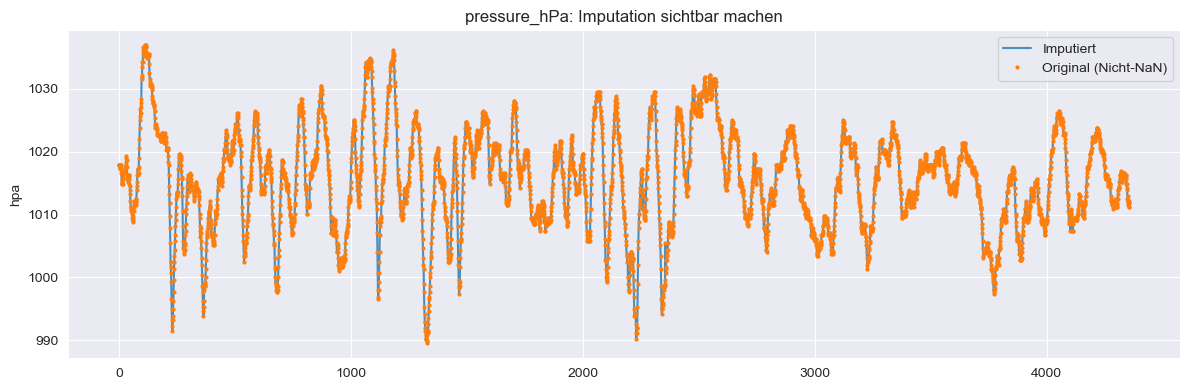

mean before: 1015.5958502068609
mean after: 1015.5958502068609
std deviation before: 7.935764852218195
std deviation after: 7.935764852218195


In [103]:
weather_data_before_imputation = weather_data_raw
weather_data_raw.set_index('datetime_hour', inplace=True)
weather_data_raw['pressure_hPa'] = weather_data_raw['pressure_hPa'].interpolate(method='time')
weather_data_raw.reset_index(inplace=True)
plt.figure(figsize=(12, 4))
weather_data_raw['pressure_hPa'].plot(label='Imputiert', alpha=0.8)
weather_data_raw['pressure_hPa'].where(weather_data_raw['pressure_hPa'].notna()).plot(style='o',
                                                                                      label='Original (Nicht-NaN)',
                                                                                      markersize=2)
plt.title('pressure_hPa: Imputation sichtbar machen')
plt.ylabel('hpa')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
before = weather_data_before_imputation['pressure_hPa']
after = weather_data_raw['pressure_hPa']

print("mean before:", before.mean())
print("mean after:", after.mean())
print("std deviation before:", before.std())
print("std deviation after:", after.std())

In [104]:
weather_data_raw.isna().sum()

datetime_hour        0
temp                 0
windspeed          889
humidity             0
precip               0
pressure            20
dailyprecip          0
dailysnow            0
fog                112
rain                 0
snow                 0
conditions           0
hour_of_day          0
hour_of_year         0
temp_c               0
windspeed_kph        0
precip_mm            0
pressure_hPa         0
precip_daily_mm      0
daily_snow_mm        0
rain_class           0
rain_code            0
snow_class           0
snow_code            0
cloud_class          0
cloud_code           0
hazy_class           0
hazy_code            0
freezing_class       0
freezing_code        0
fog_class          112
fog_code           112
temp_class           0
temp_code            0
windspeed_class      0
windspeed_code       0
humidity_class       0
humidity_code        0
pressure_class       0
pressure_code        0
dtype: int64

# Save Weather Data

In [105]:
weather_data_raw.to_csv("data/weather_data_clean.csv", index=False)